#Realtime Multi-Person 2D Pose Estimation using Part Affinity Fields

## Introduction

The estimation of human posture is the process of modeling the human body as a set of some parts (e.g., arms, legs, torso, etc.) and finding their positions in an image. Several studies have been developed in order to generate these estimates in real time using various techniques of Deep Learning. In this Notebook we study the development done in [[1]](https://ieeexplore-ieee-org.ezproxy.imt-atlantique.fr/document/8099626), which makes use of Part Affinity Fields for this purpose.

Inferring the pose of multiple people in images, especially socially engaged individuals, presents a unique set of challenges. First, each image may contain an unknown number of people that can occur at any position or scale. Second, interactions between people induce complex spatial interference, due to contact, occlusion, and limb articulations, making association of parts difficult. Third, runtime complexity tends to grow with the number of people in the image, making realtime performance a challenge.

In [[1]](https://ieeexplore-ieee-org.ezproxy.imt-atlantique.fr/document/8099626), a method for estimating the posture of various persons at multiple public reference points is presented. It uses the ascending representation of association scores through the part affinity fields (PAF), a set of 2D vector fields that encode the location and orientation of the limbs over the image domain. These bottom-up representations of detection and association are simultaneously inferred and encode the global context of the scene.

First, we will download the repository that we copied from [the original repository](https://github.com/tensorboy/pytorch_Realtime_Multi-Person_Pose_Estimation) in order to make some changes for educational purposes. Then, we install libraries and some dependences explained in the original repository.

In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
colab_path = "/content/gdrive/My Drive/Colab Notebooks/"

# Independence install
!sudo apt-get install swig
%cd $colab_path
# Repository clone
!git clone https://github.com/Johansmm/RT-multiperson-pose-pytorch.git
%cd "RT-multiperson-pose-pytorch"
# Libraries install
!python -m pip install -r ./requirements.txt
!git submodule init && git submodule update
%cd lib/pafprocess 
# Repository compile
!sh make.sh
%cd $colab_path"/RT-multiperson-pose-pytorch"
# Weights download
if not os.path.isfile("./pose_model.pth"):
  !wget https://www.dropbox.com/s/ae071mfm2qoyc8v/pose_model.pth


Mounted at /content/gdrive
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 11 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (841 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize fro

In [2]:
%cd $colab_path"/RT-multiperson-pose-pytorch"
!python "./demo/picture_demo.py"

/content/gdrive/My Drive/Colab Notebooks/RT-multiperson-pose-pytorch
Bulding VGG19
0.5459940652818991


## 

**Libraries**

In [6]:
import os
import re
import sys
sys.path.append('.')
sys.argv=['']
del sys
import cv2
import math
import time
import scipy
import argparse
import matplotlib
import numpy as np
import pylab as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from scipy.ndimage.morphology import generate_binary_structure
from scipy.ndimage.filters import gaussian_filter, maximum_filter

from lib.network.rtpose_vgg import get_model 
from lib.network import im_transform
from evaluate.coco_eval import get_outputs, handle_paf_and_heat
from lib.utils.common import Human, BodyPart, CocoPart, CocoColors, CocoPairsRender, draw_humans
from lib.utils.paf_to_pose import paf_to_pose_cpp
from lib.config import cfg, update_config

In [7]:
parser = argparse.ArgumentParser()
parser.add_argument('--cfg', help='experiment configure file name',
                    default='./experiments/vgg19_368x368_sgd.yaml', type=str)
parser.add_argument('--weight', type=str,
                    default='pose_model.pth')
parser.add_argument('opts',
                    help="Modify config options using the command-line",
                    default=None,
                    nargs=argparse.REMAINDER)
args = parser.parse_args()

# update config file
update_config(cfg, args)

Bulding VGG19


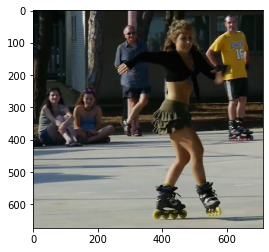

In [12]:
model = get_model('vgg19')     
model.load_state_dict(torch.load(args.weight))
model = torch.nn.DataParallel(model).cuda()
model.float()
model.eval()

test_image = './readme/ski.jpg'
oriImg = cv2.imread(test_image) # B,G,R order
shape_dst = np.min(oriImg.shape[0:2])

destRGB = cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB)
imgplot = plt.imshow(destRGB)
plt.show()

0.5459940652818991


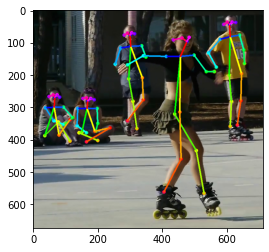

In [13]:
# Get results of original image

with torch.no_grad():
    paf, heatmap, im_scale = get_outputs(oriImg, model,  'rtpose')
          
print(im_scale)


humans = paf_to_pose_cpp(heatmap, paf, cfg)        
out = draw_humans(oriImg, humans)
#cv2.imwrite('result.png',out)   
destRGB_out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
imgplot = plt.imshow(destRGB_out)
plt.show()

In [22]:
import seaborn as sns; sns.set_theme()

precip_2002_2013 = np.array([[1.07, 0.44, 1.5],
                              [0.27, 1.13, 1.72]])

precip_2002_2013.shape
#ax = sns.heatmap(heatmap)

(2, 3)